In [39]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('train.csv',nrows=20000)

train_df['hour'] = train_df['timestamp'] // 3600000 % 24
train_df['day_of_week'] = train_df['timestamp'] // 86400000 % 7

train_df['correct_answers'] = train_df.groupby('user_id')['answered_correctly'].transform('sum')
train_df['avg_time_taken'] = train_df.groupby('user_id')['prior_question_elapsed_time'].transform('mean')
train_df['correct_rate'] = train_df.groupby('user_id')['answered_correctly'].transform(lambda x: x.sum() / x.count())

train_df['content_type'] = train_df['content_type_id'].apply(lambda x: 'Вопрос' if x == 0 else 'Лекция')
train_df['task_container_id'] = train_df['task_container_id']

train_df['content_id_count'] = train_df.groupby(['user_id', 'content_id']).size().reset_index(name='content_id_count')['content_id_count']

print(train_df.head())


   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

  prior_question_had_explanation  hour  day_of_week  correct_answers  \
0                            NaN     0

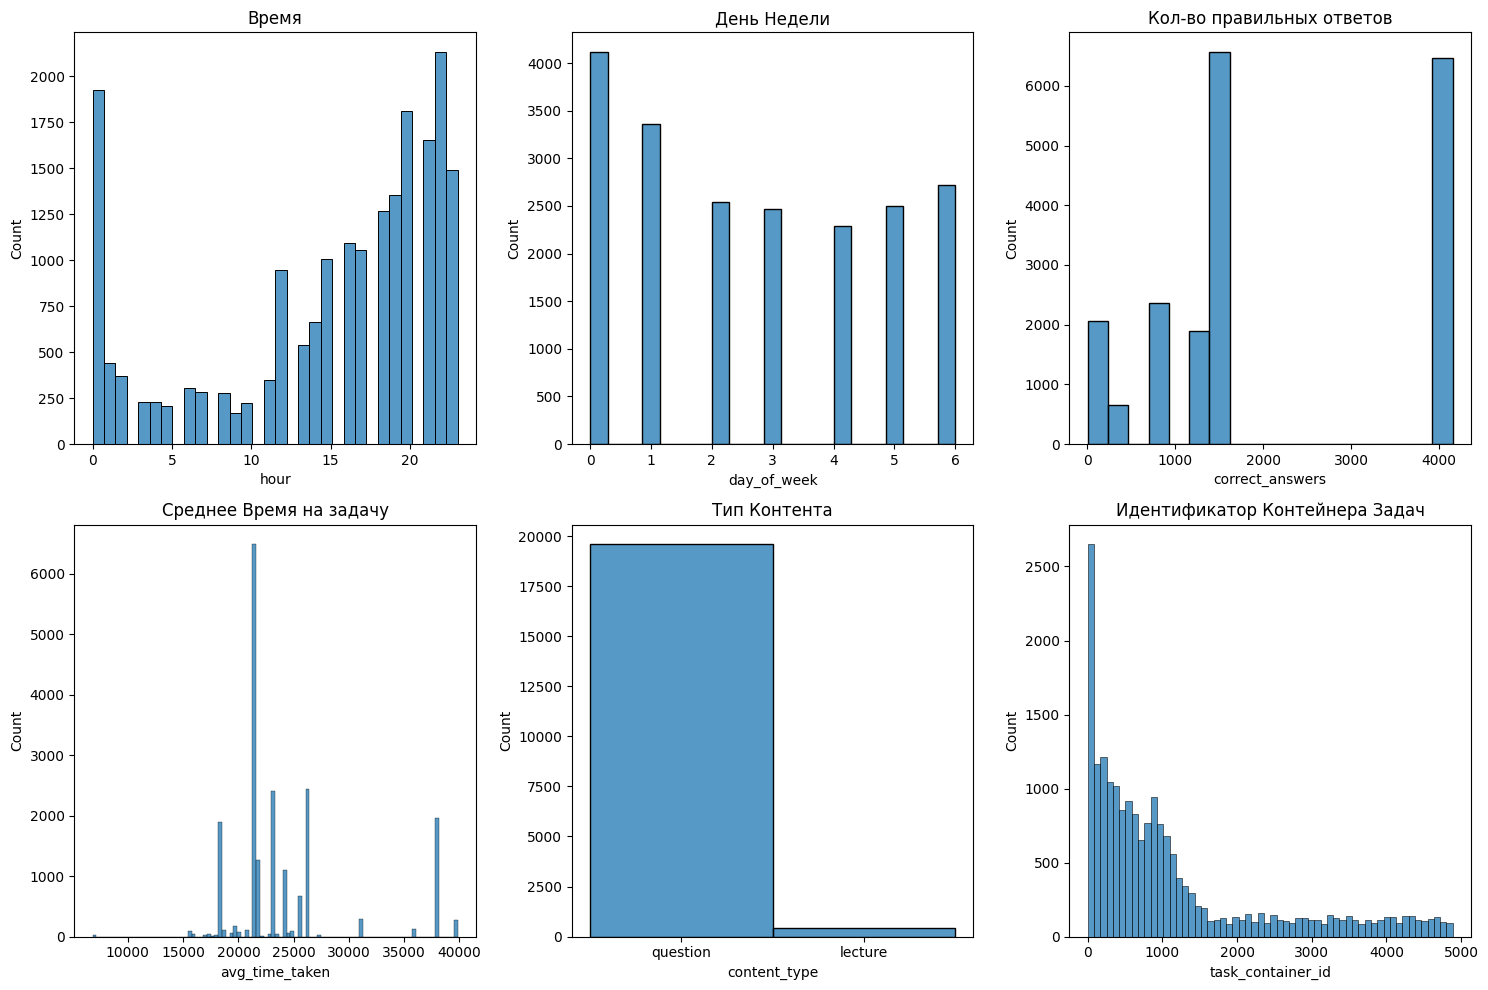

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(train_df['hour'], ax=axs[0, 0])
sns.histplot(train_df['day_of_week'], ax=axs[0, 1])
sns.histplot(train_df['correct_answers'], ax=axs[0, 2])
sns.histplot(train_df['avg_time_taken'], ax=axs[1, 0])
sns.histplot(train_df['content_type'], ax=axs[1, 1])
sns.histplot(train_df['task_container_id'], ax=axs[1, 2])

axs[0, 0].set_title('Время')
axs[0, 1].set_title('День Недели')
axs[0, 2].set_title('Кол-во правильных ответов')
axs[1, 0].set_title('Среднее Время на задачу')
axs[1, 1].set_title('Тип Контента')
axs[1, 2].set_title('Идентификатор Контейнера Задач')

plt.tight_layout()
plt.show()


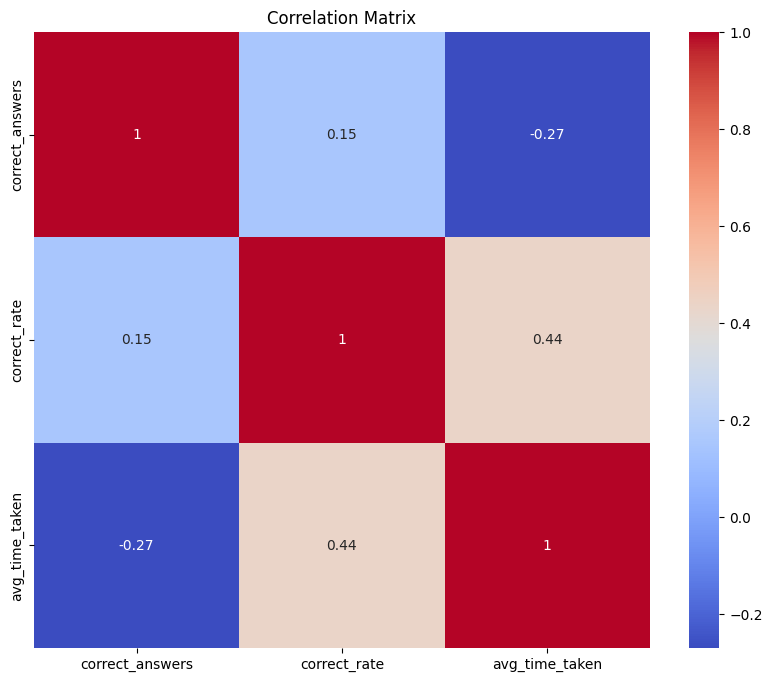

In [51]:
corr_features = [ 'correct_answers','correct_rate', 'avg_time_taken']

corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


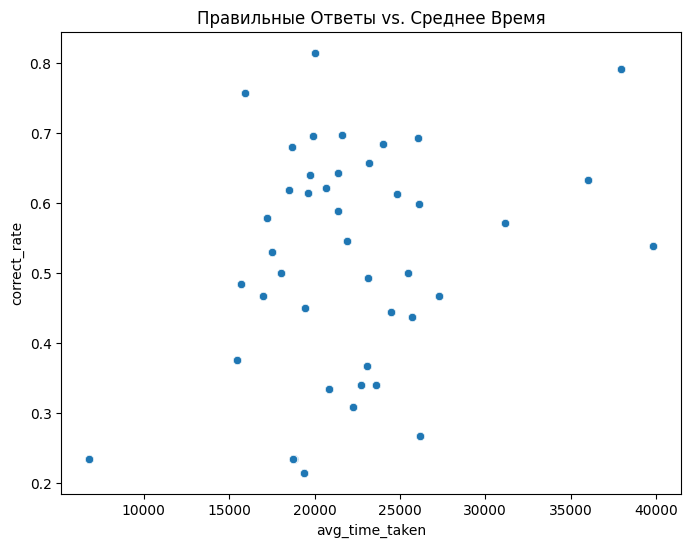

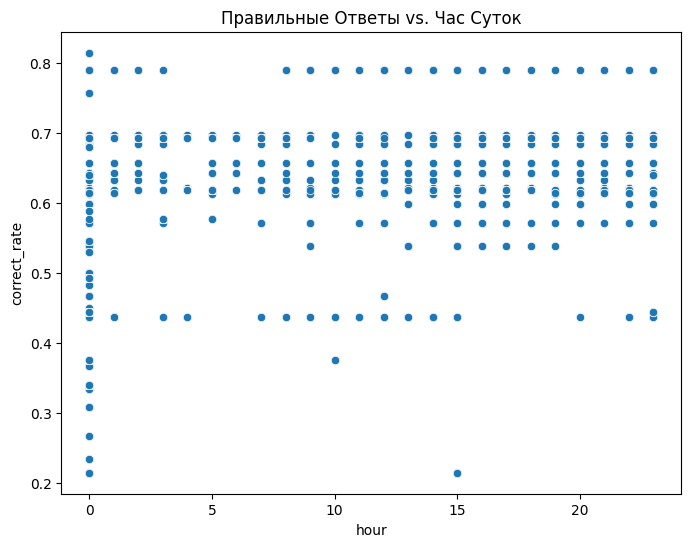

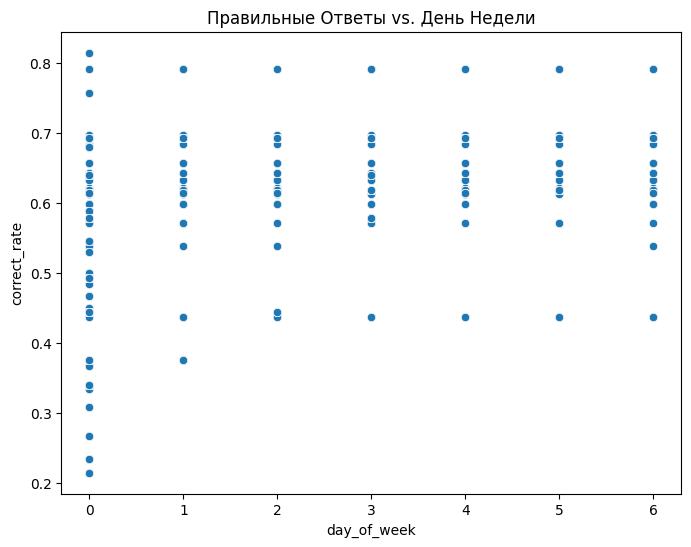

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_time_taken', y='correct_rate', data=train_df)
plt.title('Правильные Ответы vs. Среднее Время')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='hour', y='correct_rate', data=train_df)
plt.title('Правильные Ответы vs. Час Суток')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='day_of_week', y='correct_rate', data=train_df)
plt.title('Правильные Ответы vs. День Недели')
plt.show()


In [53]:
import pandas as pd


# Calculate the number of questions answered for each user
user_questions_answered = train_df.groupby('user_id')['content_id'].count()

# Calculate the time spent for each user
user_time_spent = train_df.groupby('user_id')['timestamp'].max() - train_df.groupby('user_id')['timestamp'].min()

# Calculate the correct answer rate for each user
user_correct_answer_rate = train_df.groupby('user_id')['answered_correctly'].mean()



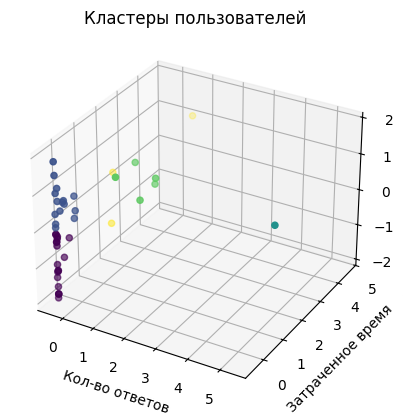

In [57]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

user_metrics_df = pd.DataFrame({
    'user_id': train_df['user_id'].unique(),
    'questions_answered': user_questions_answered.values,
    'time_spent': user_time_spent.values,
    'correct_answer_rate': user_correct_answer_rate.values
})

scaler = StandardScaler()
user_metrics_scaled_df = pd.DataFrame(scaler.fit_transform(user_metrics_df[['questions_answered', 'time_spent', 'correct_answer_rate']]), columns=['questions_answered_scaled', 'time_spent_scaled', 'correct_answer_rate_scaled'])

kmeans = KMeans(n_clusters=5)

kmeans.fit(user_metrics_scaled_df)

user_metrics_scaled_df['cluster'] = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(user_metrics_scaled_df['questions_answered_scaled'], user_metrics_scaled_df['time_spent_scaled'], user_metrics_scaled_df['correct_answer_rate_scaled'], c=user_metrics_scaled_df['cluster'])

ax.set_xlabel('Кол-во ответов')
ax.set_ylabel('Затраченное время')
ax.set_zlabel('Отношение правильных ответов')

plt.title('Кластеры пользователей')
plt.show()
